In [3]:
import os
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


Dataset size: (4508785, 2)
Missing values:
de    0
en    0
dtype: int64


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


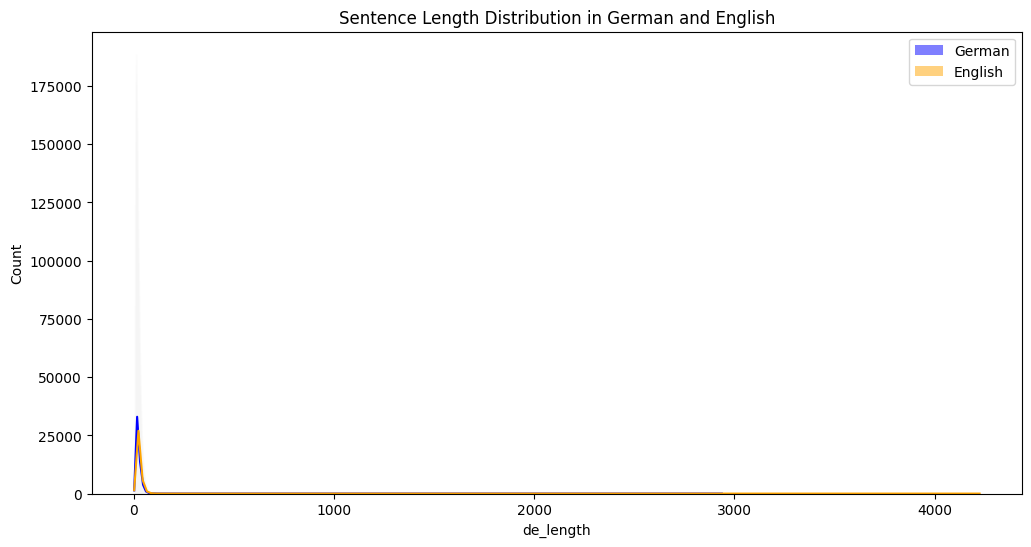

In [5]:
dataset = pd.read_csv('../data/wmt14_translate_de-en_train.csv', lineterminator='\n')

# Explore the dataset
display(dataset.head())
print(f'Dataset size: {dataset.shape}')
print(f'Missing values:\n{dataset.isnull().sum()}')

dataset.describe()

# Plot length of sentences in German and English
dataset['de_length'] = dataset['de'].apply(lambda x: len(x.split()))
dataset['en_length'] = dataset['en'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(dataset['de_length'], color="blue", label="German", kde=True)
sns.histplot(dataset['en_length'], color="orange", label="English", kde=True)
plt.legend()
plt.title('Sentence Length Distribution in German and English')
plt.show()


In [4]:
train_raw = pd.read_csv('../data/wmt14_translate_de-en_train.csv', lineterminator='\n', nrows=4500)
test_raw = pd.read_csv('../data/wmt14_translate_de-en_test.csv', lineterminator='\n')
val_raw = pd.read_csv('../data/wmt14_translate_de-en_validation.csv', lineterminator='\n')

In [10]:
train_raw.shape

(4500, 2)

In [11]:
train_raw.head()

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


In [5]:
# Function to clean the text data (e.g., lowercasing, removing special characters)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Clean both German and English text
train_raw['de'] = train_raw['de'].apply(clean_text)
train_raw['en'] = train_raw['en'].apply(clean_text)
val_raw['de'] = val_raw['de'].apply(clean_text)
val_raw['en'] = val_raw['en'].apply(clean_text)
test_raw['de'] = test_raw['de'].apply(clean_text)
test_raw['en'] = test_raw['en'].apply(clean_text)

# Tokenization and padding
def tokenize_and_pad(texts, max_len=30):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences, tokenizer

# Prepare German and English tokenizers and sequences
max_len = 30  # Set a suitable max length for padding
train_de_sequences, de_tokenizer = tokenize_and_pad(train_raw['de'], max_len)
train_en_sequences, en_tokenizer = tokenize_and_pad(train_raw['en'], max_len)
val_de_sequences, _ = tokenize_and_pad(val_raw['de'], max_len)
val_en_sequences, _ = tokenize_and_pad(val_raw['en'], max_len)
test_de_sequences, _ = tokenize_and_pad(test_raw['de'], max_len)
test_en_sequences, _ = tokenize_and_pad(test_raw['en'], max_len)

# Vocabulary sizes
de_vocab_size = len(de_tokenizer.word_index) + 1  # Add 1 for padding token
en_vocab_size = len(en_tokenizer.word_index) + 1  # Add 1 for padding token 

print(f'German vocabulary size: {de_vocab_size}')
print(f'English vocabulary size: {en_vocab_size}')

German vocabulary size: 21011
English vocabulary size: 14532


In [57]:
# Encoder Class
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_state=True)
    
    def call(self, inputs):
        x = self.embedding(inputs)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c


# Decoder Class with Attention Mechanism
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.attention = Attention()
        self.dense = TimeDistributed(Dense(vocab_size, activation='softmax'))

    def call(self, inputs, context_vector, initial_state):
        x = self.embedding(inputs)
        lstm_output, _, _ = self.lstm(x, initial_state=initial_state)
        attention_output = self.attention([lstm_output, context_vector])
        decoder_concat_input = Concatenate()([lstm_output, attention_output])
        output = self.dense(decoder_concat_input)
        return output

In [58]:
def build_model(en_vocab_size, de_vocab_size, embedding_dim, hidden_units, max_len):
    # Encoder
    encoder_input = Input(shape=(max_len,), name='encoder_input')
    encoder_emb = Embedding(en_vocab_size, embedding_dim, input_length=max_len)(encoder_input)
    encoder_lstm = LSTM(hidden_units, return_state=True, dropout=0.5)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_input = Input(shape=(max_len - 1,), name='decoder_input')  # Shifted by 1
    decoder_emb = Embedding(de_vocab_size, embedding_dim, input_length=max_len-1)(decoder_input)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.5)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)
    
    decoder_dense = Dense(de_vocab_size, activation='softmax')
    decoder_output = decoder_dense(decoder_lstm_out)
    
    model = Model([encoder_input, decoder_input], decoder_output)
    
    return model

embedding_dim = 256
lstm_units = 512

model = build_model(en_vocab_size, de_vocab_size, embedding_dim, lstm_units, max_len)

# Print model summary
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 30, 256)   │  3,720,192 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 29, 256)   │  5,378,816 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 512),     │  1,574,912 │ embedding_18[0][… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 29, 512), │  1,574,912 │ embedding_19[0][… │
│                     │ (None, 512),      │            │ lstm_18[0][1],    │
│                     │ (None, 512)]      │            │ lstm_18[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 29, 21011) │ 10,778,643 │ lstm_19[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,027,475 (87.84 MB)

 Trainable params: 23,027,475 (87.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3514 - loss: 7.0933 - val_accuracy: 0.4556 - val_loss: 4.3896
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.3838 - loss: 4.9845 - val_accuracy: 0.4577 - val_loss: 4.3352
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3898 - loss: 4.8035 - val_accuracy: 0.4544 - val_loss: 4.4236
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3859 - loss: 5.0157 - val_accuracy: 0.4547 - val_loss: 4.4390
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3953 - loss: 4.6329 - val_accuracy: 0.4561 - val_loss: 4.5048
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.3998 - loss: 4.4919 - val_accuracy: 0.4555 - val_loss: 4.5789
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4048 - loss: 4.3697 - val_accuracy: 0.4549 - val_loss: 4.6562
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4051 - loss: 4.2871 - val_accuracy: 0.4563 - val_loss: 4.

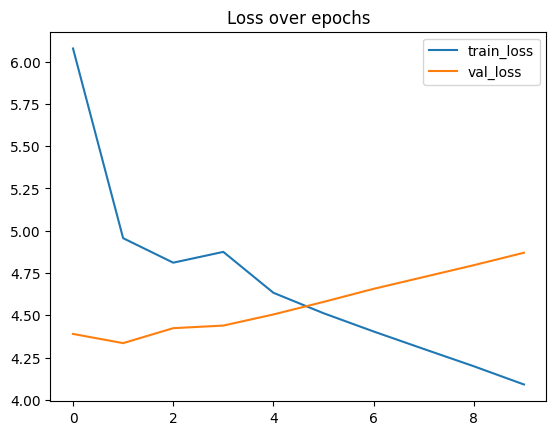

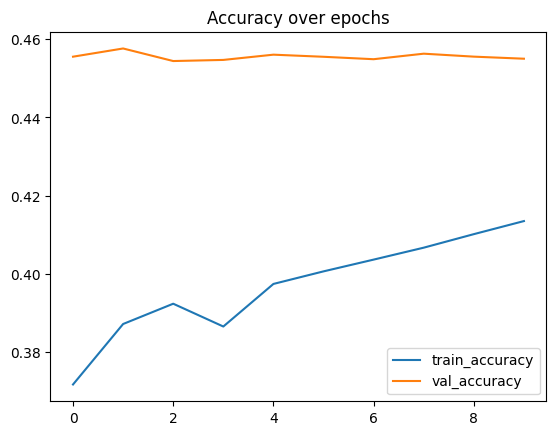

In [59]:
train_en_sequences = pad_sequences(train_en_sequences, maxlen=max_len, padding='post')
train_de_sequences = pad_sequences(train_de_sequences, maxlen=max_len, padding='post')

# Decoder input and output (padded to match sequence length)
decoder_input = train_de_sequences[:, :-1]  # Shifted German sequence
decoder_output = np.expand_dims(train_de_sequences[:, 1:], -1)  # Shifted German sequence

# Train the model (do not redefine the model here)
# Training example: Pass encoder_input and decoder_input with appropriate shapes
history = model.fit(
    [train_en_sequences, train_de_sequences[:, :-1]],
    np.expand_dims(train_de_sequences[:, 1:], -1),
    epochs=10,
    batch_size=64,
    validation_data=(
        [val_en_sequences, val_de_sequences[:, :-1]],
        np.expand_dims(val_de_sequences[:, 1:], -1)
    )
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()


In [60]:
model_path = '../checkpoints/seq2seq_attention'
model.save(f'{model_path}.weights.keras')

In [6]:
model_path = '../checkpoints/seq2seq_attention'
restored_model = tf.keras.models.load_model(f'{model_path}.weights.keras')

preds = restored_model.predict([test_en_sequences[:5], test_de_sequences[:5, :-1]])

# Function to convert sequences to text
def sequences_to_text(sequences, tokenizer):
    word_index = tokenizer.word_index
    index_word = {v: k for k, v in word_index.items()}
    return ' '.join(index_word[i] for i in sequences if i != 0)

# Convert the sequences to text
for i in range(5):
    print(f'English: {sequences_to_text(test_en_sequences[i], en_tokenizer)}')
    print(f'German: {sequences_to_text(test_de_sequences[i], de_tokenizer)}')
    print(f'Predicted German: {sequences_to_text(np.argmax(preds[i], axis=1), de_tokenizer)}')
    print()
    

2024-11-08 19:13:56.080424: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
English: the group enable function with 1994 result years in tu no committee ellos su spaces on the support would and we competence years
German: veränderungen bei die grundwerte entschließung habe in das vom natürliches fraktion noch schwierigkeiten herausgabe wissenschaftlichen leistungen im pool
Predicted German: ist der kommission der die dass der der europäischen der der die die und der und europäischen der

English: kofi or which we century arrived keyword my all international nuclear
German: den stimme um ich sehr lage publikationen et letzten 15 einerseits so
Predicted German: präsidentin der der und die und der der

English: procedure an who manufacturers looked was these requirements that annan a robberies a from tree cross matters observed whole
German: ich hat ein menschen neun geleitet jetzt ja die ist der siehe über nationalstaaten und verschreibungspflichtigen hat frau über als alkohol ende von trinken
Predicted German: ist die beri